# Continuous Waves

In addition to the GW stochastic background, we expect a number of closer, louder sources to stand out to us. These are high-mass, inspiraling black hole binaries with orbital frequencies roughly between 1 and 100 nHz, which evolve very slowly over the course of PTA observations. Because of their slow evolution, PTA experiments don't witness these binaries changing much in orbital frequency, i.e., PTAs don't see that distinct "chirp" like LIGO does. Therefore, we call these signals "continuous gravitational waves", or CWs.

Continuous wave searches are a bit different than PTA searches for the GWB. CWs are deterministic signals, meaning that, for a single binary emitting GWs, we can model the entire waveform! In theory this makes the search simpler. But in reality, there are a lot of parameters that we need to model to make this work.

In this exercise, we'll start with simulated pulsar timing data that has been injected with a CW signal. First, we'll get a sense of how our array of pulsars will respond to the signal and then inspect the timing residuals by eye. Then we'll investigate how different parameters affect the delays induced by a CW. In the last few sections, we'll set up both frequentist and Bayesian MCMC runs to see how much information we can recover. By doing so with a few different setups, by the end of this tutorial, you should have some understanding of not only the numerous steps necessary to run a CW search, but also ***why*** they're necessary! 

# 0. Package installation & imports
Follow the instructions in the link below to install `QuickCW` in your conda environment. **Note:** When you get to the step to clone the QuickCW repo, make sure you clone it in the same directory as this notebook! We'll use this package later on in this tutorial.

https://github.com/nanograv/QuickCW/blob/main/docs/how_to_run_QuickCW.md <br>

In [1]:
# imports

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
import pickle
import os, glob

from enterprise.pulsar import Pulsar
from enterprise import constants as const
import corner

In [2]:
# output directory will be the same as this notebook - feel free to change this if you'd like
outdir = './'

# 1. Detector & simulated data
### Read in simulated data
Let's start out with a simple array of 3 pulsars observed over a timespan of 10 years. These simulated pulsars have randomized sky locations, pulse frequencies, and parallaxes, and all are placed at a distance of 1 kpc. (For real pulsars, a distance of 1 kpc is generally a good assumption if we don't already have any distance measurements available.) The simulated data was generated with some mildly correlated white noise as well as an injected CW source. We can describe the CW signal using the following 8 parameters:

- position on the sky, ($\theta, \phi$) $\rightarrow$ these are related to the declination and right ascension as $\theta = \frac{\pi}{2} - \delta$ and $\phi = \alpha$ (in rad)
    - declination $\delta$ $\in [-90^\rm{o},90^\rm{o}] \rightarrow$ polar angle $\theta \in [\pi,0]$ rad
    - right ascension $\alpha \in [0^\rm{o},360^\rm{o}] \rightarrow$ azimuthal angle $\phi \in [0,2\pi]$ rad
<br>
- luminosity distance, $d_L > 0$ (Mpc)
- GW frequency, $f_{\rm{GW}} \in [10^{-9},10^{-7}]$ (Hz)
- chirp mass, $\mathcal{M} \in [10^7,10^{10}]$ (M$_\odot$)
- orbital inclination, $\iota \in [0,\pi]$
- GW polarization angle, $\psi \in [0,\pi]$
- orbital phase at some reference time, $\Phi_0 \in [0,2\pi]$

In the simulated 3-pulsar-dataset we'll use, the injected CW source is in the approximate location and distance of the Virgo Cluster of galaxies. The sky location is ($\alpha$, $\delta$) = (12h27m, +12d43') and the distance is about 15 Mpc. (Quoted distances for the Virgo Cluster range from $\sim$ 15 to 22 Mpc.) Run the cell below to store the injected CW source parameters.

In [3]:
# binary parameters for injected CW signal

# sky location
ra_in = (12 + 27/60)*15  #degrees (hours x 15 = degrees)
dec_in = 12 + 43/60      #degrees

# convert sky location from degrees to radians
gwtheta_in = np.pi/2 - dec_in*np.pi/180  #theta = pi/2 - dec
gwphi_in = ra_in*np.pi/180

# parameters related to the strain amplitude
dist_in = 15   #distance in Mpc
fgw_in = 1e-8  #GW frequency in Hz
mc_in = 5e9    #binary chirp mass in solar masses

# angular parameters
inc_in = 0     #inclination angle of the binary in rad (inc=0 is a face-on binary)
psi_in = 0     #GW polarization angle in rad
phase0_in = 0  #initial orbital phase of the binary in rad

And run the cell below to read in the simulated data.

In [4]:
# read in enterprise pulsar objects
with open(outdir + 'sim_data/psr3_dataset.pkl', 'rb') as psrfile:
    epsrs = pickle.load(psrfile)

### What does our detector look like?

Before we take a look at our residuals, let's get some familiarity with the PTA's response to a CW signal. In the following cells, we'll plot the antenna pattern response. This shows how strongly a pulsar at any position on the sky will be affected by a CW source in a given location.

The function `plot_apf` will plot the antenna response functions across the sky, the positions of our 3 pulsars, and the position of our injected GW source.

In [5]:
from enterprise.signals.utils import create_gw_antenna_pattern
import healpy as hp

In [6]:
def plot_apf(psrs, gwtheta, gwphi):
    
    '''
    Function to plot the antenna response pattern of the simulated PTA.
    
    psrs: enterprise pulsar objects
    gwtheta: theta coordinate of the GW source
    gwphi: phi coordinate of the GW source
    
    '''
    
    # skymap resolution of N_side = 8
    npix = hp.nside2npix(8)

    # setting up skymap plotting
    theta, phi = hp.pix2ang(8, range(768))
    data_p_pos = np.zeros(npix)
    data_x_pos = np.zeros(npix)
    data_m_pos = np.zeros(npix)
    for pix in range(npix):
        theta, phi = hp.pix2ang(8, pix)
        pos = np.array([np.sin(theta)*np.cos(phi), 
                        np.sin(theta)*np.sin(phi), 
                        np.cos(theta)])
        data_p_pos[pix],data_x_pos[pix], data_m_pos[pix] = create_gw_antenna_pattern(pos,gwtheta,gwphi)
    
    # plot antenna response pattern
    names = ['Plus', 'Cross', '$\cos \mu$']
    fig, axes = plt.subplots(1, 3, figsize=(18,12))
    for d, dat in enumerate([data_x_pos, data_p_pos, data_m_pos]):
        plt.axes(axes[d])
        mv = hp.mollview(dat, rot=180, title=names[d], hold=True, cmap='binary_r')

        # plot pulsar positions
        for i, psr in enumerate(psrs):
            hp.visufunc.projscatter(psr.theta, psr.phi, marker='*', s=300, edgecolor='w', color=f'C{i}')
            
        # plot GW source position
        hp.visufunc.projscatter(gwtheta, gwphi, marker='D', s=100, edgecolor='w', color='r')

        # plot axis labels by hand (healpy is weird about this)
        for i in range(2,24,2):
            text = hp.projtext(i*180/12+3, 4, str(i)+'h', lonlat=True, coord='G', fontsize='large', zorder=1, color='w')
        for i in range(-75,0,15):
            text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='large', zorder=10, color='w')
        for i in range(15,90,15):
            text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='large', zorder=10, color='w')
        
        # plot grid lines
        hp.graticule(15, 30)
        
    plt.show()

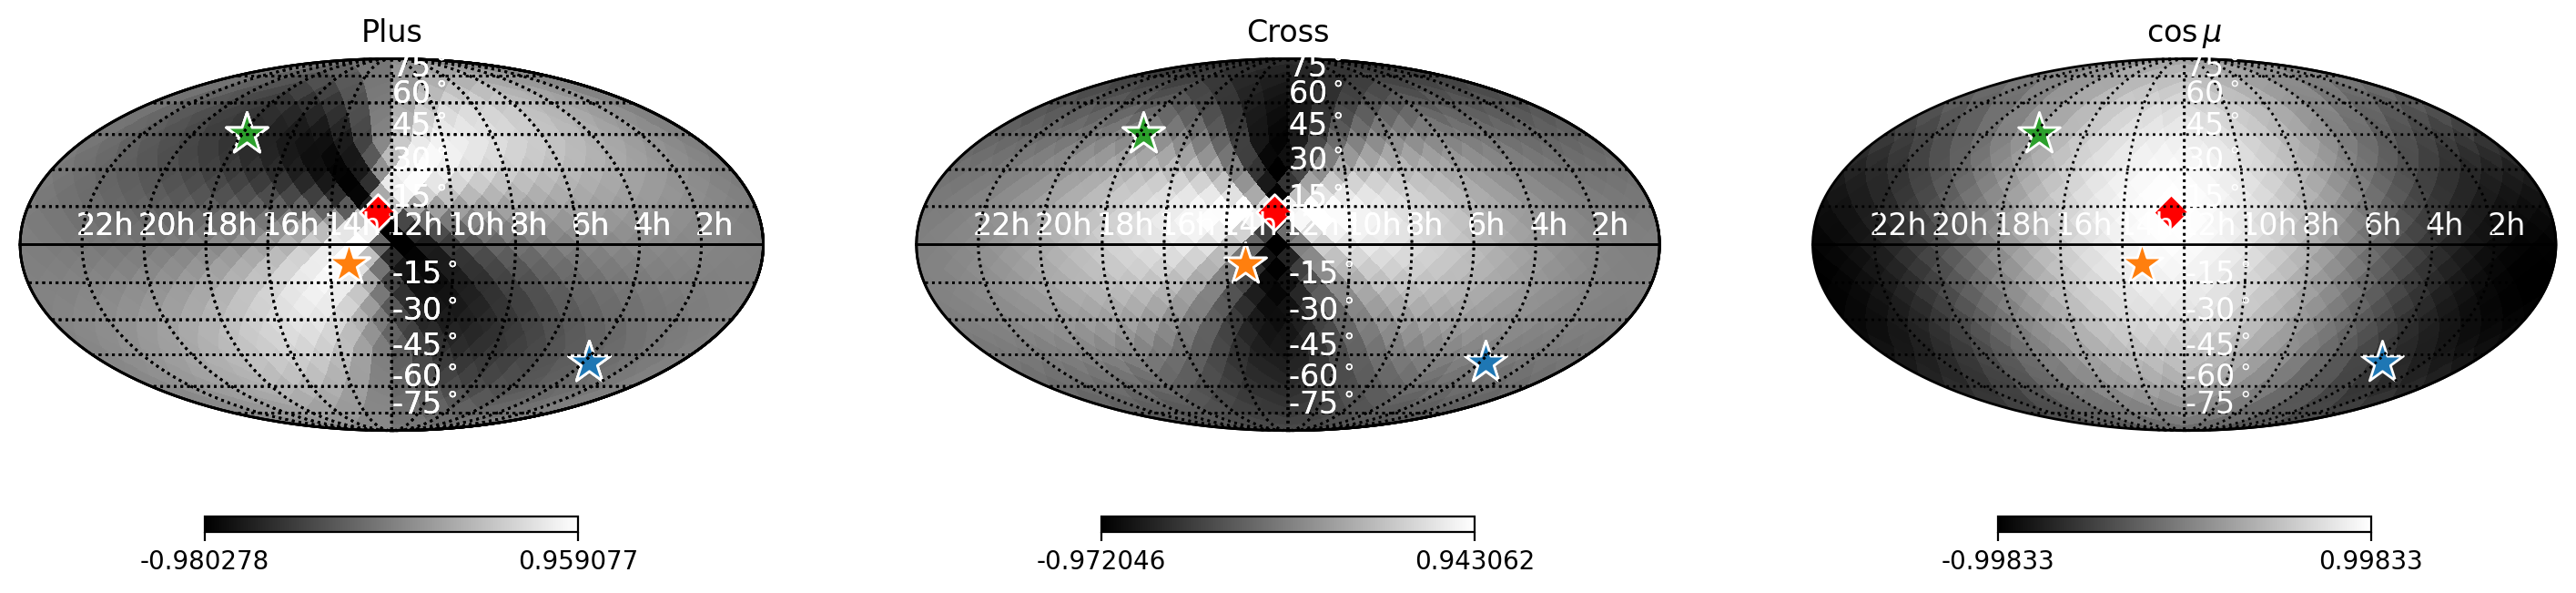

In [7]:
# plot the antenna response patterns using the enterprise pulsars and the injected CW sky location
plot_apf(epsrs, gwtheta_in, gwphi_in)

The stars are our 3 simulated pulsars and the red diamond is the injected GW source. The sky is shaded by the antenna response pattern, with positive responses in white and negative responses in black. Recall that the antenna response is informational whether it's positive or negative, while a response of 0 is insensitive to the signal. **Based on the signal responses and the pulsar locations, which pulsars do you think will be most/least sensitive to the GW signal?**

### What do the timing residuals look like?
Check your predictions by plotting each pulsar's residuals.

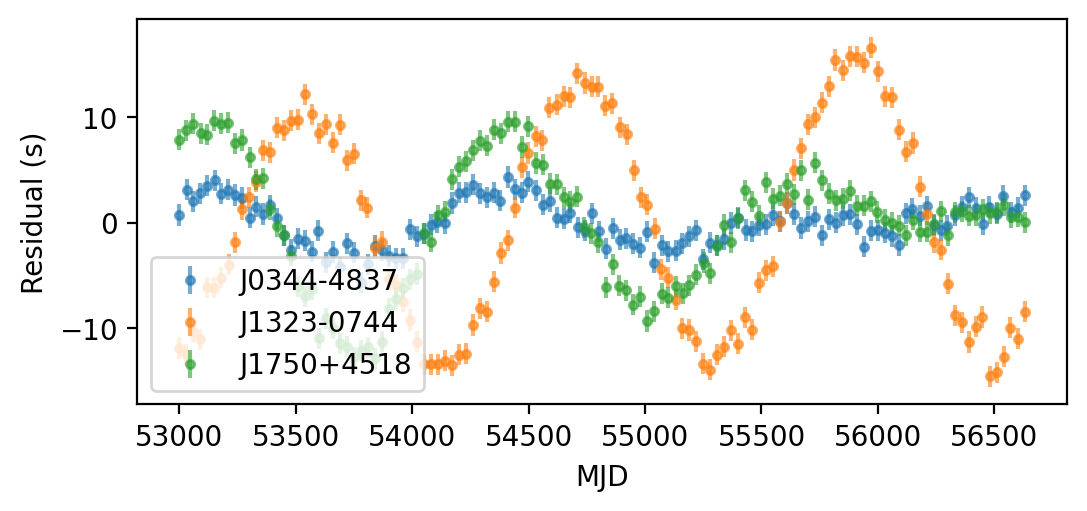

In [8]:
plt.figure(figsize=(6,2.5))
for i,p in enumerate(epsrs):
    plt.errorbar((p.toas*u.second).to(u.day), p.residuals/1e-6, p.toaerrs/1e-6, fmt='.', alpha=0.6, color=f'C{i}', label=p.name)
plt.legend(loc='lower left', fontsize=10)
plt.xlabel('MJD')
plt.ylabel('Residual (s)')
plt.show() 

In the space below, let's read in a different dataset, still using the same pulsars as our detector but with a CW signal injected in a different location (i.e., new gwtheta and gwphi coordinates). Re-plot the antenna responses and the observing data for each pulsar to see how the waveforms change.

In [9]:
with open(outdir + 'sim_data/psr3_dataset2.pkl', 'rb') as psrfile:
    epsrs2 = pickle.load(psrfile)

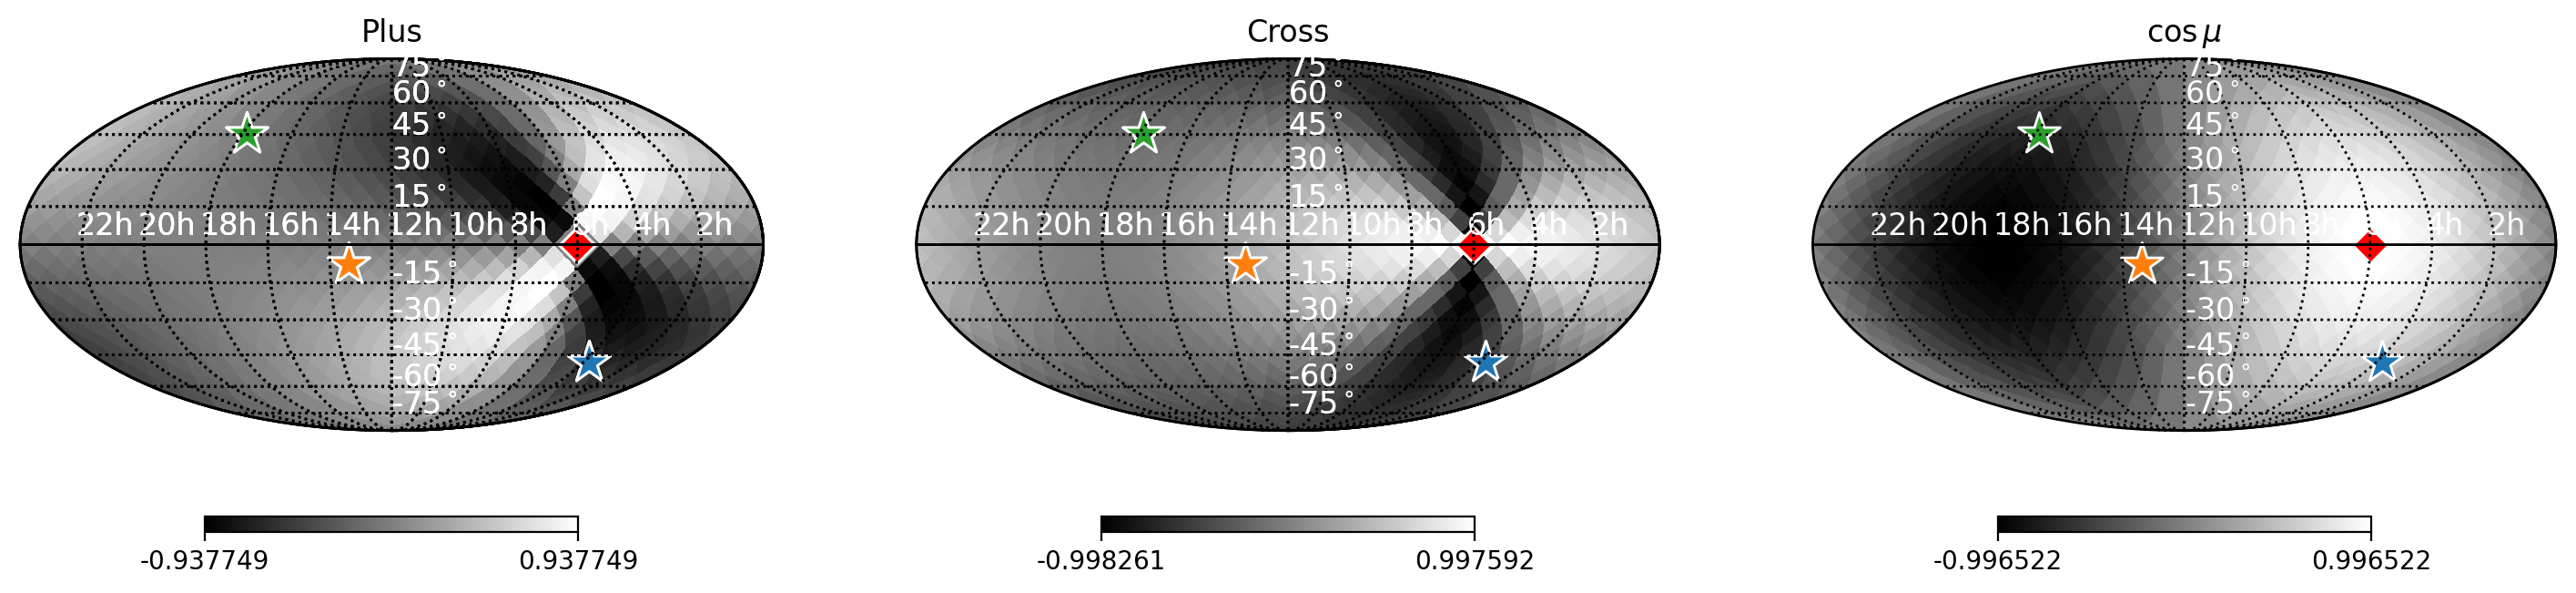

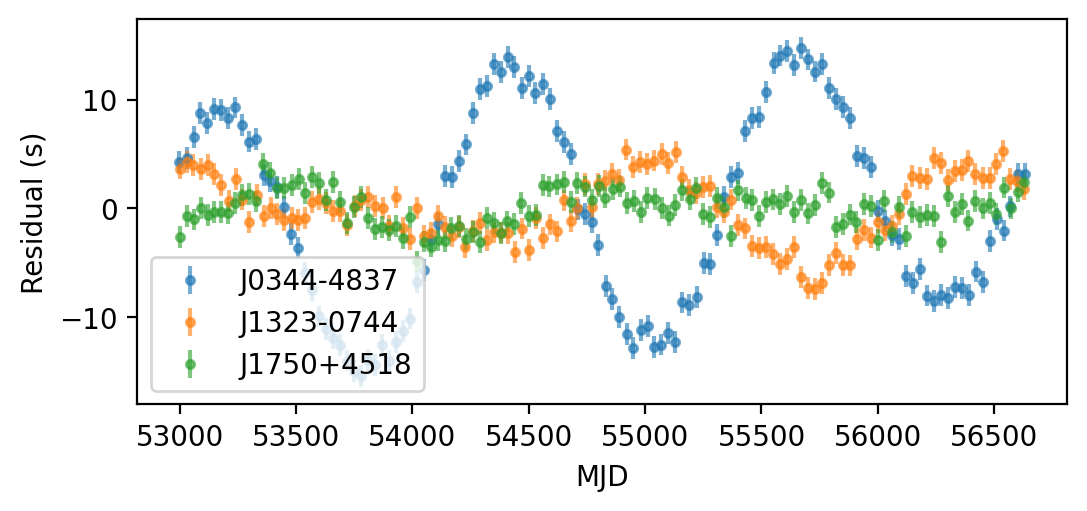

In [10]:
# plot antenna response patterns
apf_plots = plot_apf(epsrs2, np.pi/2, gwphi=6*15*np.pi/180)

# plot residuals
plt.figure(figsize=(6,2.5))
for i,p in enumerate(epsrs2):
    plt.errorbar((p.toas*u.second).to(u.day), p.residuals/1e-6, p.toaerrs/1e-6, fmt='.', alpha=0.6, color=f'C{i}', label=p.name)
plt.legend(loc='lower left', fontsize=10)
plt.xlabel('MJD')
plt.ylabel('Residual (s)')
plt.show() 

**How do the waveforms change when the location of the CW source changes? Did the sensitivities of the pulsars change, i.e., can you more clearly see a CW signal in a pulsar that didn't show the signal before?**

# 2. Investigating the CW signal
### Earth term + pulsar term
Let's take a closer look at the form of the CW signal. You might've already noticed that, aside from any noise in the residuals we plotted above, a CW is not just a sinusoid! There are a few interesting pieces within these waveforms that are important to disentangle. A little bit of math:

We'll represent the signal produced by an individual binary using the vector $\boldsymbol{s}$. This vector can be written as:

$$
\begin{equation}
s(t) = F^+(\theta, \phi, \psi)[s_+(t_p) - s_+(t)] + F^{\times}(\theta, \phi, \psi)[s_{\times}(t_p) - s_{\times}(t)]
\end{equation}
$$

where $F^{+,\times}$ are those antenna pattern functions we plotted earlier, describing the pulsars' response to the GW source. $s_{+,\times}(t)$ is the signal induced at the Earth (called the "Earth term") at some time $t$ when the GW passes the Earth, and $s_{+,\times}(t_p)$ is the signal induced at the pulsar (called the "pulsar term") at some time $t_p$ when the GW passes the pulsar. These times $t$ and $t_p$ are related to each other by:

$$
\begin{equation}
t_p = t - L(1 - \cos\mu)
\end{equation}
$$

where $L$ is the distance to the pulsar and $\mu$ is the angle between the GW origin and the pulsar's position on the sky. (We plotted $\cos\mu$ in the maps above too.)

The full influence of a GW passing through our pulsar array is therefore a **combination of the measurements of the signal at the Earth and at each pulsar individually**. If the wave jiggles Earth, then the TOAs for all the pulsars in the array will change. We encapsulate this portion of the signal effect into the "Earth term". But, every pulsar experiences a jiggle too, and since the pulsar's pulses take time to reach us, we essentially see the signal in the past, before it reached Earth. This is the "pulsar term" in our residuals.

To see this more clearly, we'll decompose the CW signal into these two terms and plot them using `enterprise_extensions`.

In [11]:
from enterprise_extensions.deterministic import cw_delay

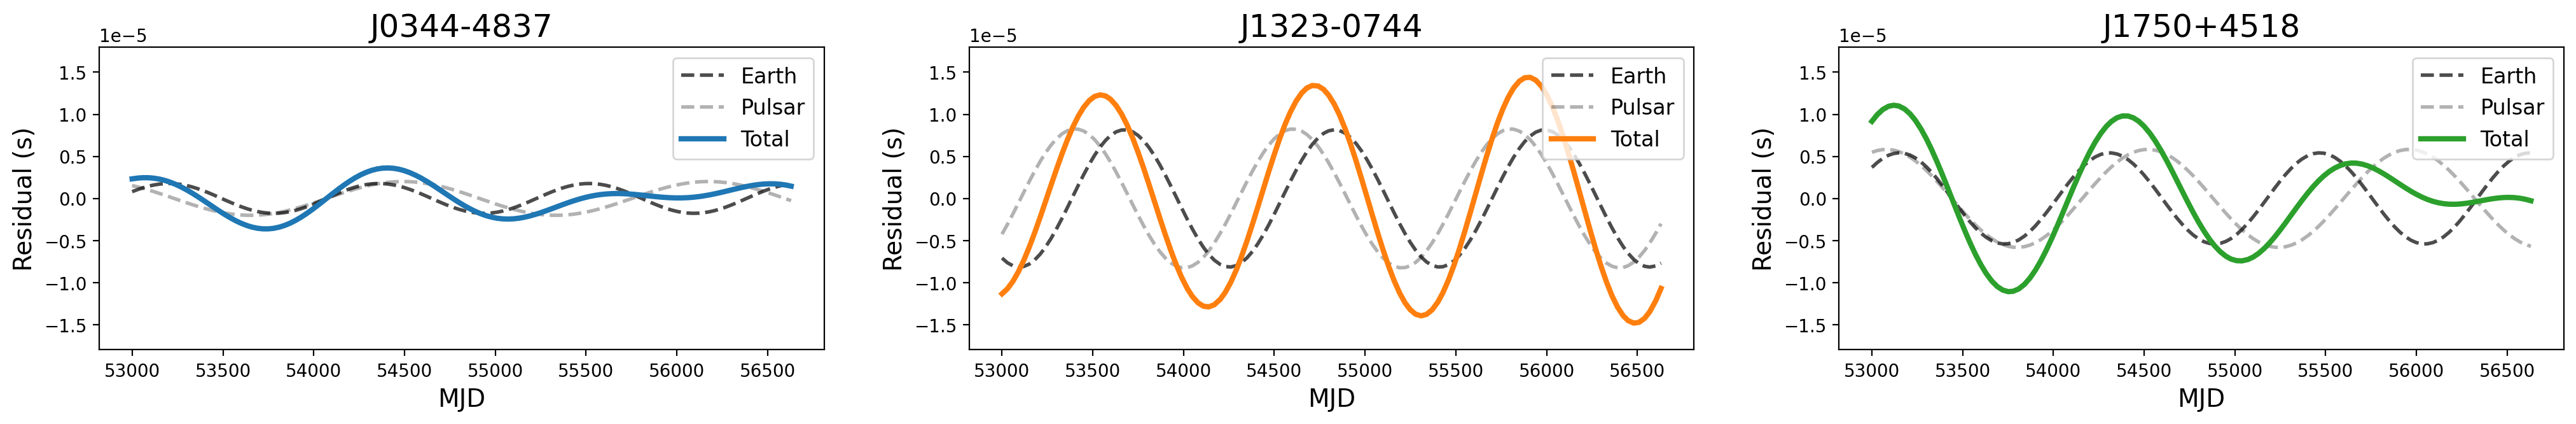

In [12]:
# it's important to choose a logical reference time for your CW model
# we'll use the last TOA in the dataset for this tutorial
tref = max([p.toas.max() for p in epsrs])

# breaking down the two signal components for each pulsar in our array
plt.figure(figsize=(25, 3.5*3))
for i, psr in enumerate(epsrs):
    ax = plt.subplot(3, 3, i+1)
    
    # this is the Earth term ONLY signal, with the parameter psrTerm=False
    cw_e = cw_delay(psr.toas, psr.pos, pdist=(1.0, 0.2),
                    cos_gwtheta=np.cos(gwtheta_in), gwphi=gwphi_in, log10_dist=np.log10(dist_in),
                    log10_fgw=np.log10(fgw_in), log10_mc=np.log10(mc_in),
                    cos_inc=np.cos(inc_in), psi=psi_in, phase0=phase0_in, p_dist=0,
                    psrTerm=False, evolve=False, phase_approx=True, tref=tref)

    # this is the FULL signal, with the parameter psrTerm=True
    cw_total = cw_delay(psr.toas, psr.pos, pdist=(1.0, 0.2),
                        cos_gwtheta=np.cos(gwtheta_in), gwphi=gwphi_in, log10_dist=np.log10(dist_in),
                        log10_fgw=np.log10(fgw_in), log10_mc=np.log10(mc_in),
                        cos_inc=np.cos(inc_in), psi=psi_in, phase0=phase0_in, p_dist=0,
                        psrTerm=True, evolve=False, phase_approx=True, tref=tref)

    # there's no option to create a pulsar term only signal in enterprise_extensions
    # so we have to subtract (full signal) - (earth term only) = (pulsar term only)
    cw_p = cw_total - cw_e
    
    # plot all three together
    ax.set_title(psr.name, fontsize=18)
    ax.plot((psr.toas*u.second).to(u.day), cw_e, color='k', alpha=0.7, lw=2, ls='--', marker='', label='Earth')
    ax.plot((psr.toas*u.second).to(u.day), cw_p, color='k', alpha=0.3, lw=2, ls='--', marker='', label='Pulsar')
    ax.plot((psr.toas*u.second).to(u.day), cw_total, color=f'C{i}', lw=3, marker='', label='Total')
    ax.legend(fontsize='large', loc='upper right')
    ax.set_ylim(-1.8e-5, 1.8e-5)
    ax.set_xlabel('MJD', fontsize=14)
    ax.set_ylabel('Residual (s)', fontsize=14)

plt.show()

### Pulsar distances

The distance to the pulsar also has a big effect on the residuals when we're modeling the pulsar term. The wavelength of our typical GWs (around ~ 1 pc) are much smaller than the uncertainties on the distances to our pulsars (typically around ~ 200 pc), so small changes in the pulsar distance can have important consequences on the shape of the residuals. In the block below, we'll draw a few values from a normal distribution of pulsar distances and plot the output of `cw_delay` to compare to the input signal.

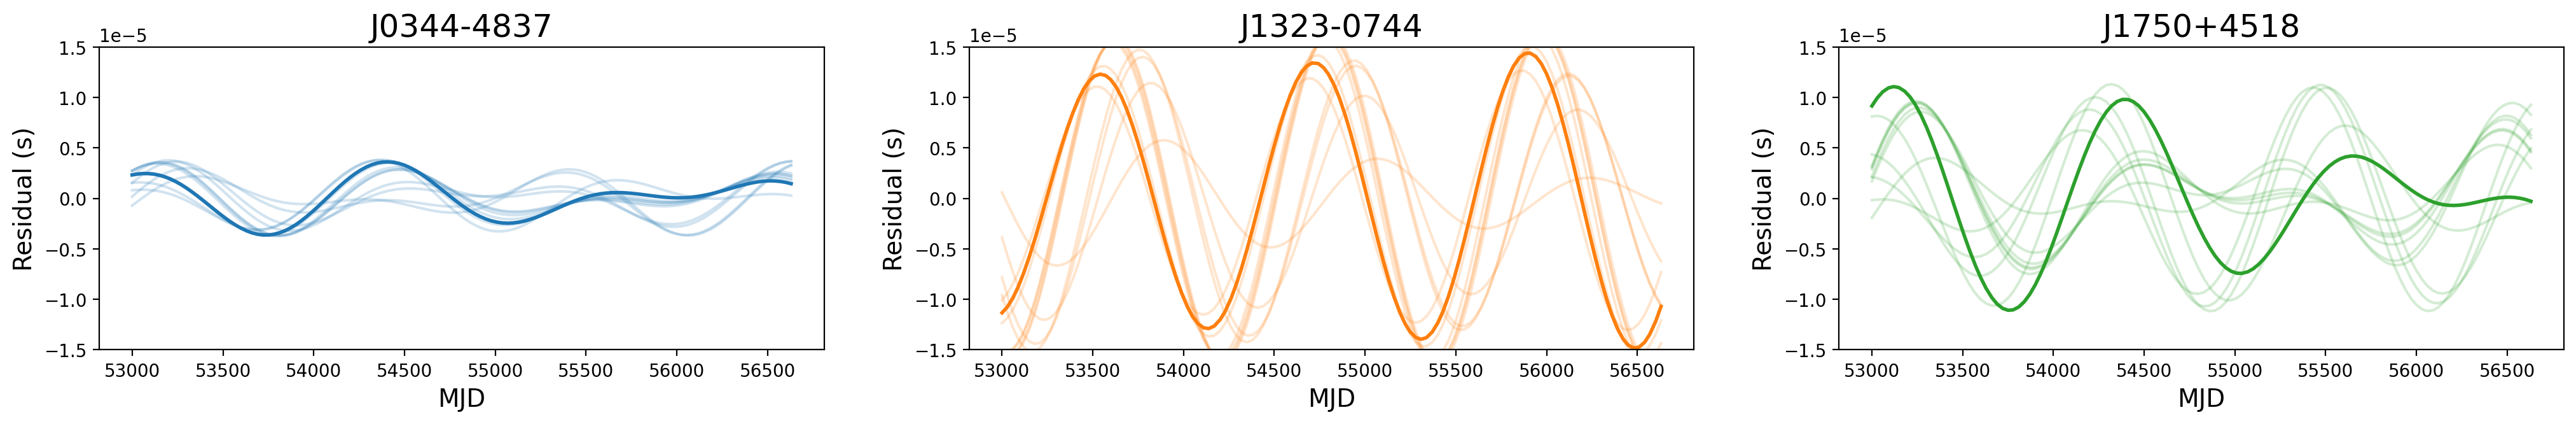

In [13]:
# number of values to draw
N = 10
n_psrs = 3

# normal distribution of pulsar distances
test_pd = np.random.randn(N,n_psrs)*0.2+1

plt.figure(figsize=(25, 3.5*n_psrs))
for i, psr in enumerate(epsrs):
    ax = plt.subplot(n_psrs, 3, i+1)

    # input CW signal with injected pulsar distance of 1.0 +/- 0.2 kpc
    cw_in = cw_delay(psr.toas, psr.pos, pdist=(1.0, 0.2),
                     cos_gwtheta=np.cos(gwtheta_in), gwphi=gwphi_in, log10_dist=np.log10(dist_in), 
                     log10_fgw=np.log10(fgw_in), log10_mc=np.log10(mc_in),
                     cos_inc=np.cos(inc_in), psi=psi_in, phase0=phase0_in, p_dist=0,
                     psrTerm=True, evolve=False, phase_approx=True, tref=tref)

    # same input CW signals but with different pulsar distances
    for d, dist in enumerate(test_pd):
        cwd = cw_delay(psr.toas, psr.pos, pdist=(dist[i], 0.2),
                       cos_gwtheta=np.cos(gwtheta_in), gwphi=gwphi_in, log10_dist=np.log10(dist_in), 
                       log10_fgw=np.log10(fgw_in), log10_mc=np.log10(mc_in),
                       cos_inc=np.cos(inc_in), psi=psi_in, phase0=phase0_in, p_dist=0,
                       psrTerm=True, evolve=False, phase_approx=True, tref=tref)
        ax.plot((psr.toas*u.second).to(u.day), cwd, color=f'C{i}', marker='', alpha=0.2)

    # plotting
    ax.plot((psr.toas*u.second).to(u.day), cw_in, color=f'C{i}', marker='', lw=2, alpha=1)
    ax.set_ylim(-1.5e-5, 1.5e-5)
    ax.set_title(psr.name, fontsize=18)
    ax.set_xlabel('MJD', fontsize=14)
    ax.set_ylabel('Residual (s)', fontsize=14)

**Try choosing more distance values (or even some specific values of the pulsar distance) to see how much of an effect this can have.** Compare with friends too!

In [14]:
# space to explore pulsar distances



So why is the pulsar term so important anyways? **The answer to this question is that the pulsar term helps us to better recover the CW source properties.** If we have no prior knowledge about our CW source, the only information we can recover from our search is about the strain amplitude:

$$
\begin{equation}
h_{0} = \frac{2 \mathcal{M}^{5/3}(\pi f_{\rm{GW}})^{2/3}}{d_{L}}
\end{equation}
$$

where $\mathcal{M}$ is the chirp mass, $f_{\rm{GW}}$ is the GW frequency, and $d_L$ is the luminosity distance to the source. Since the strain is a combination of these parameters, we need some other information in order to get estimates of their values independently. Luckily, this is where the pulsar terms come in: the pulsar terms provide us with snapshots of the orbital dynamics of the system. These pulsar-specific snapshots lag behind the Earth term snapshot by some time $t - t_p$ as we saw earlier. This makes it possible for us to measure the change in frequency between the pulsar terms and the Earth term, and hence, the chirp mass!

But note that this doesn't allow us to separate out ALL the parameters above, so you'll typically see CW analyses searching over either the strain amplitude $h_0$ or the luminosity distance $d_L$, but not both.

### CW parameter exploration

Take some time now to explore the CW signal for yourself. Using the space below and the `cw_delay` function, try different parameter values and plot the resulting signal. **Which parameters affect the strength of the signal? Which parameters produce a bigger difference between the Earth term and pulsar term frequencies?** Compare results with friends and consult the hints below if you need them.

In [15]:
# space to explore the CW signal



#### Hints

From our strain equation above, we can see that more massive systems or higher frequency systems are "louder", with the binary chirp mass $\mathcal{M}$ having a larger effect than the GW frequency $f_{\rm{GW}}$. The inverse dependence on the binary's luminosity distance $d_L$ results in closer systems being louder as well.

As the binary loses energy due to the emission of GWs, the orbital frequency evolves over time as

$$
\begin{equation}
\frac{\mathrm{d}\omega}{\mathrm{d}t} = \frac{96}{5}\mathcal{M}^{5/3}\omega(t)^{11/3}.
\end{equation}
$$

Therefore, if the chirp mass or orbital frequency are higher, the binary's orbit will evolve more quickly, and the difference between the Earth and pulsar term frequencies will be bigger.

# 3. Frequentist analyses

There are two frequentist statistics we can use for CW searches $-$ the $\mathcal{F}_e$ statistic and the $\mathcal{F}_p$ statistic $-$ both of which are maximum likelihood estimators.

**The $\mathcal{F}_e$ statistic** is a maximum likelihood estimator of the **sky location** $(\theta$, $\phi)$ and **GW frequency** $(f_{\rm{GW}})$ of an individually-resolvable SMBHB. The signal model includes only the Earth term component. This statistic can be mapped over different GW frequencies and sky locations or globally maximized to find the best-fit values of these parameters.

**The $\mathcal{F}_p$ statistic** is a maximum likelihood estimator of the **GW frequency** $(f_{\rm{GW}})$ of an individually-resolvable SMBHB. It's similar to the $\mathcal{F}_e$ statistic, but it also accounts for the pulsar term component and, in doing so, assumes that the source evolves slowly enough that the Earth term and pulsar term frequencies are identical or indistinguishable within the PTA resolution. This statistic can be mapped over a range of GW frequencies.

For more (math), see: <br>
https://arxiv.org/abs/1112.1075 <br>
https://arxiv.org/abs/1204.4218

### Set up the signal model

To calculate these statistics, we first need to set up our signal model using `enterprise` and `enterprise_extensions`.

In [16]:
from enterprise.signals import parameter, selections
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import signal_base
from enterprise_extensions.deterministic import CWSignal

In [17]:
# white noise fixed at the level that was injected
efac = parameter.Constant(1)
selection = selections.Selection(selections.no_selection)
ef = white_signals.MeasurementNoise(efac=efac, selection=selection)

# timing model
tm = gp_signals.TimingModel()

# CW signal with priors for each parameter
# assumes NO evolution across the observing timespan of the dataset
# assumes YES evolution between pulsar terms and Earth term
cw_wf = cw_delay(cos_gwtheta=parameter.Uniform(-1, 1)('cos_gwtheta'),
                 gwphi=parameter.Uniform(0, 2*np.pi)('gwphi'),
                 log10_dist=parameter.Uniform(1, 4)('log10_dL'),
                 log10_mc=parameter.Uniform(7, 10)('log10_mc'),
                 log10_fgw=parameter.Uniform(-9, -7)('log10_fgw'),
                 cos_inc=parameter.Uniform(-1, 1)('cos_inc'),
                 psi=parameter.Uniform(0, np.pi)('psi'),
                 phase0=parameter.Uniform(0, 2*np.pi)('phase0'),
                 p_dist=parameter.Normal(0, 1),
                 p_phase=parameter.Uniform(0, 2*np.pi),
                 phase_approx=True, #approximation that the wave is monochromatic
                 psrTerm=True,
                 evolve=False,
                 tref=tref)
cw = CWSignal(cw_wf, psrTerm=True)

# define the full signal model
s = ef + tm + cw

### Create an `enterprise` PTA object

In [18]:
# use the simulated pulsars & model to initialize the PTA
model = [s(psr) for psr in epsrs]
pta = signal_base.PTA(model)

### The $\mathcal{F}_p$ search

Let's try the $\mathcal{F}_p$ search first, since it involves just one parameter: the GW frequency. We'll do a quick grid search over frequencies from 1 to 100 nHz and find where the $\mathcal{F}_p$ statistic is highest. The frequency at this highest $\mathcal{F}_p$ value should then ideally be close to the true injected GW frequency.

In [19]:
from enterprise_extensions.frequentist.F_statistic import FpStat

First we need to set up our `FpStat` object with our simulated pulsars and model.

In [20]:
# instantiate the FpStat object
# main inputs here are the simulated dataset (in the form of pulsar objects) and the PTA object
Fp_obj = FpStat(epsrs, noisedict={}, psrTerm=True,
                bayesephem=False, pta=pta, tnequad=False)

Now calculate the $\mathcal{F}_p$ statistic for each frequency. Whether we're doing a frequentist or Bayesian search, we typically search over frequencies in log space. The $\mathcal{F}_p$ statistic is calculated with the `compute_Fp` method of the `FpStat` class.

In [21]:
# set up our grid of frequencies
N_freqs = 500
freqs = np.logspace(-9, -7, N_freqs)

# compute Fp statistic for each frequency
Fps = [Fp_obj.compute_Fp(freq) for freq in freqs]

/tmp/ipykernel_53019/1593774354.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(___, ___, marker='o', markersize=4, ls='-', alpha=0.7)


IndexError: string index out of range

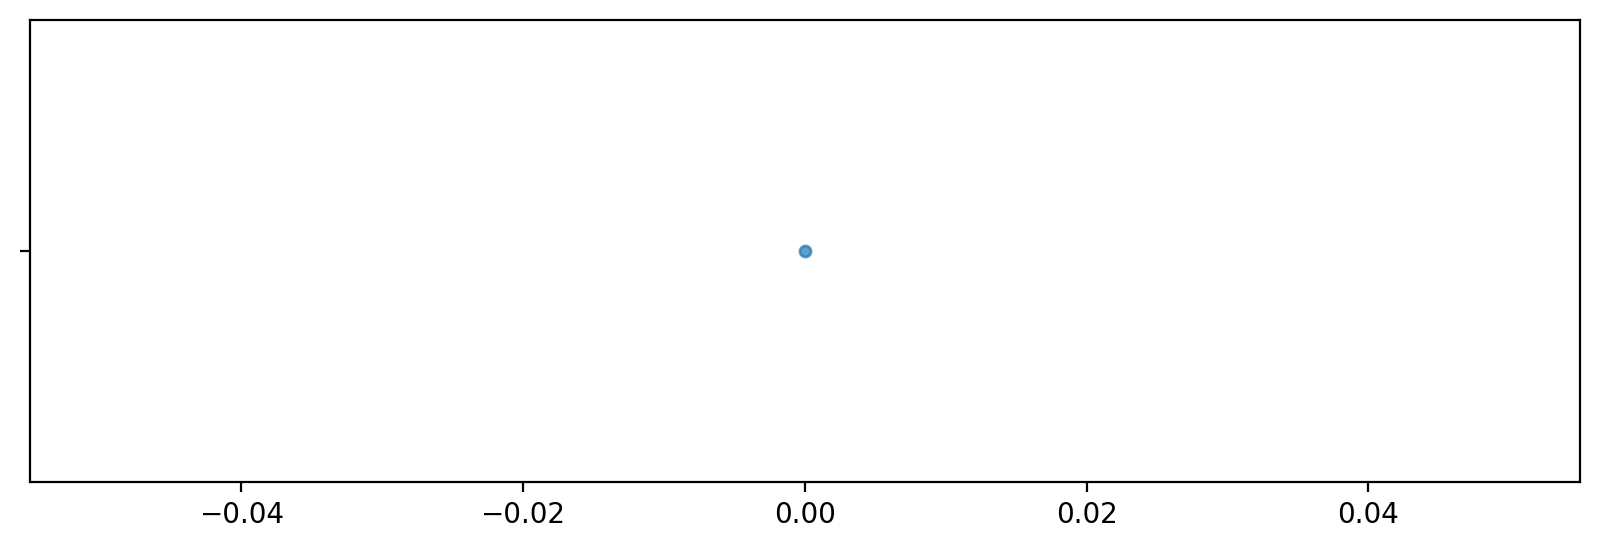

In [22]:
# let's plot the Fp statistic as a function of frequency
plt.figure(figsize=(10,3))
plt.plot(___, ___, marker='o', markersize=4, ls='-', alpha=0.7)

# find the frequency at the maximum Fp value and plot it
w_max = np.argmax(___)
fgw_rec = ___[w_max]
plt.axvline(___, color='k', ls='dashed', lw=2, label=f'recovered = {round(np.log10(fgw_rec), 2)}')

# plot the correct, injected frequency
plt.axvline(___, color='r', label=f'correct = {np.log10(fgw_in)}')

#plt.yscale('log')
plt.xlabel('log10_fgw')
plt.ylabel('Fp statistic')
plt.legend(loc='upper right')
plt.show()

**What is the maximum likelihood frequency you recovered?** Compare this value to the injected frequency. **Did your grid search return the right value?**

### The $\mathcal{F}_e$ search

This time we're dealing with 3 parameters: the GW frequency and the sky location. We can do this search in a few different ways. One option is to do a grid search again, but it would probably be time-consuming to try many combinations of parameters. Another option is to globally maximize over the $\mathcal{F}_e$ statistic to find the best-fit values of these parameters, i.e., use the $\mathcal{F}_e$ statistic as our likelihood function in an MCMC analysis.

We'll go with option 2 here. And to make it easier on ourselves, we can keep the frequency constant at the value we recovered from the $\mathcal{F}_p$ search and **just look for the best-fit sky location**. Again, we need to set up our `FeStat` object with our simulated pulsars and model. Here we're using a modified version of the `FeStat` class that exists in `enterprise_extensions`.

In [ ]:
from cw_utils import FeStat
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

In [ ]:
Feobj = FeStat(epsrs, params={}, pta=pta)

Next, we need to set up our prior and likelihood functions before setting up the MCMC sampler. Since we're doing an all-sky search, the priors on our sky location will take up the entire sky. **One subtle note is that we search over $\cos\theta$ and $\phi$**; otherwise, searching over $\theta$ and $\phi$ would result in samples that are not uniformly distributed in declination, i.e., the samples would be clustered at the poles. For our likelihood function, we'll use the $\mathcal{F}_e$ statistic as a 2D likelihood that takes the sky location parameters as inputs.

In [ ]:
def logLikelihood_2d(x):
    like = Feobj.compute_Fe(f0=fgw_rec, gw_skyloc=np.array([[np.arccos(x[0])],[x[1]]]), tref=tref)
    return np.log10(like)

def logPrior_2d(x):
    # costheta prior of [-1,1]
    if x[0] < -1.0 or x[0] > 1.0:
        return float(-np.inf)
    # phi prior of [0, 2pi]
    elif x[1] < 0.0 or x[1] > 2*np.pi:
        return float(-np.inf)
    else:
        tprior = 1/(1.-(-1.))
        pprior = 1/(2*np.pi-0.0)
        return np.log10(tprior * pprior)

Finally, run the cell below to sample using `PTMCMCSampler`. It took me ~ 3 minutes to run for 25,000 iterations, so keep that in mind when setting the number of iterations. Start out small and rerun the cell later with more iterations (setting `resume=True` means your sampler will pick up where you left off)!

In [ ]:
ndim = 2
cov = np.diag(np.ones(ndim) * 0.01**2)
Fe_sampler = ptmcmc(ndim, logLikelihood_2d, logPrior_2d, cov, outDir=outdir+'fe_samples/', resume=True)

# randomly choose starting samples
Fe_x0 = np.array([np.random.random(1)[0]*2-1,       #random cos_gwtheta in [-1, 1]
                  np.random.random(1)[0]*2*np.pi])  #random gwphi in [0, 2pi]

print('Sampling...')
N_iter = 25000 #number of iterations
Fe_sampler.sample(Fe_x0, N_iter, SCAMweight=30, AMweight=15, DEweight=50)

### Visualize results
Let's see how well the $\mathcal{F}_e$ statistic did in finding the correct sky location.

In [ ]:
# read in the chain
chain = np.loadtxt(outdir+'fe_samples/chain_1.txt')

In [ ]:
# set burn-in
burn = int(len(chain)/4)

# injected parameters
inj_params = [np.cos(gwtheta_in), gwphi_in]
par_names = ['cos_gwtheta', 'gwphi']

# plot trace plots
plt.figure(1, figsize=(15, 38))
for i in range(2):
    plt.subplot(19, 4, i+1)
    plt.plot(chain[burn:,i], alpha=0.6)
    plt.axhline(inj_params[i], color='k')
    plt.title(par_names[i])
plt.tight_layout()

# plot histograms
plt.figure(2, figsize=(15, 38))
for i in range(2):
    plt.subplot(19, 4, i+1)
    plt.hist(chain[burn:,i], bins=30, histtype='step', lw=2, alpha=0.6)
    plt.axvline(inj_params[i], color='k')
    plt.title(par_names[i])
plt.tight_layout()

In [23]:
# corner plot of both sky location parameters together
fig = corner.corner(chain[burn:,0:2], levels=[0.68,0.95],
                    truths=inj_params, truth_color='k', labels=par_names, color='C0')
plt.show()

NameError: name 'chain' is not defined

**Were you able to recover the sky location of the CW source?** If not, don't panic. You can always try adding more samples to your chain to better constrain the location. BUT it could also be possible that the small number of pulsars in this toy dataset might not be enough, or the array may not have sensitive enough properties, to constrain the signal. Let's try another option...

# 4. Bayesian analysis with `QuickCW`

In this section we'll try searching for the CW signal using the full form of the likelihood. To do this, we'll use `QuickCW`, an MCMC sampler built on top of `enterprise`. While `enterprise` constructs the priors and the signal model, `QuickCW` uses a custom likelihood calculation with a Metropolis-within-Gibbs sampler and the Multiple-Try MCMC technique. In full CW searches including both the earth term and pulsar term components of the signal, we sample over the 8 CW parameters {$\cos\theta$, $\phi$, $f_{\rm{GW}}$, $\mathcal{M}$, $h_0$, $\iota$, $\psi$, $\Phi_0$}, as well as 2$N$ pulsar parameters for $N$ pulsars in our array, corresponding to the pulsar distance $L_i$ and the binary orbital phase when the GW passes by the pulsar $\Phi_i$.

**Note:** Our setup is slightly modified compared to the default setup in the `QuickCW` repo. We're using a modified `QuickCW_v2.py` instead of `QuickCW.py`, which just contains a much simpler white noise model.

In [25]:
import QuickCW_v2 #this is that modified version
from QuickCW.QuickMCMCUtils import ChainParams

Number of cores used for parallel running:  12
adjusted number multiple tries from 2000 to be next even divisor of n_x0_extra=12, 2004


### MCMC setup
The variables below are the default sampling parameters in `QuickCW`.

In [36]:
# number of iterations (increase to 100 million - 1 billion for actual analysis)
Niter = 10_000_000

n_int_block = 10_000 #number of iterations in a block (which has one shape update and the rest are projection updates)
save_every_n = 100_000 #number of iterations between saving intermediate results (needs to be integer multiple of n_int_block)
N_blocks = np.int64(Niter//n_int_block) #number of blocks to do
fisher_eig_downsample = 2000 #multiplier for how much less to do more expensive updates to fisher eigendirections for red noise and common parameters compared to diagonal elements

n_status_update = 100 #number of status update printouts (Niter/n_status_update needs to be an integer multiple of n_int_block)
n_block_status_update = np.int64(N_blocks//n_status_update) #number of blocks between status updates

assert N_blocks%n_status_update == 0 #or we won't print status updates
assert Niter%save_every_n == 0 #or we won't save a complete block
assert Niter%n_int_block == 0 #or we won't execute the right number of blocks

# parallel tempering parameters
T_max = 3.
n_chain = 4

# where results will be saved
savedir = outdir + 'qcw_samples/'
if not os.path.exists(savedir):
    os.makedirs(savedir, exist_ok=True)

### Sample!

In [37]:
# setup and start MCMC
# object containing common parameters for the MCMC chain
chain_params = ChainParams(T_max, n_chain, n_block_status_update,
                           freq_bounds=np.array([1e-9, 1e-7]), #prior bounds used on the GW frequency (a lower bound of np.nan is interpreted as 1/T_obs)
                           n_int_block=n_int_block, #number of iterations in a block (which has one shape update and the rest are projection updates)
                           save_every_n=save_every_n, #number of iterations between saving intermediate results (needs to be intiger multiple of n_int_block)
                           fisher_eig_downsample=fisher_eig_downsample, #multiplier for how much less to do more expensive updates to fisher eigendirections for red noise and common parameters compared to diagonal elements
                           rn_emp_dist_file=None, #RN empirical distribution file to use (no empirical distribution jumps attempted if set to None)
                           savefile=savedir+'samples.h5', #hdf5 file to save to, will not save at all if None
                           thin=100, #thinning, i.e. save every `thin`th sample to file (increase to higher than one to keep file sizes small)
                           prior_draw_prob=0.2, de_prob=0.6, fisher_prob=0.3, #probability of different jump types
                           dist_jump_weight=0.2, rn_jump_weight=0.3, gwb_jump_weight=0.1, common_jump_weight=0.2, all_jump_weight=0.2, #probability of updating different groups of parameters
                           fix_rn=True, zero_rn=True, fix_gwb=True, zero_gwb=True) #switches to turn off GWB or RN jumps and keep them fixed and to set them to practically zero (gamma=0.0, log10_A=-20)
pta,mcc = QuickCW_v2.QuickCW(chain_params, epsrs, noise_json=None, include_ecorr=False, amplitude_prior='detection', 
                             psr_distance_file=None, backend_selection=False)

# some parameters in chain_params can be updated later if needed
mcc.chain_params.thin = 10

# do the main MCMC iteration
mcc.advance_N_blocks(N_blocks)

Using 4 temperature chains with a geometric spacing of 1.442.
Temperature ladder is:
 [1.         1.44224957 2.08008382 3.        ]
Overwrite rn_jump_weight to 0, due to fix_rn=True.
Overwrite gwb_jump_weight to 0, due to fix_gwb=True.
Overwrite all_jump_weight to 0, due to either fix_rn or fix_gwb being True.
Began Main Loop
Begin Loading Pulsar Timing Array from Enterprise at    0.003s
Finished Loading Pulsar Timing Array from Enterprise at    0.003s
List of parameters in the model with their priors:
[0_cos_gwtheta:Uniform(pmin=-1, pmax=1), 0_cos_inc:Uniform(pmin=-1, pmax=1), 0_gwphi:Uniform(pmin=0.0, pmax=6.283185307179586), 0_log10_fgw:Uniform(pmin=-9.0, pmax=-7.0), 0_log10_h:Uniform(pmin=-18, pmax=-11), 0_log10_mc:Uniform(pmin=7, pmax=10), 0_phase0:Uniform(pmin=0, pmax=6.283185307179586), 0_psi:Uniform(pmin=0, pmax=3.141592653589793), J0344-4837_cw0_p_dist:Normal(mu=0, sigma=1), J0344-4837_cw0_p_phase:Uniform(pmin=0, pmax=6.283185307179586), J0344-4837_red_noise_gamma:Uniform(pmin

### Visualize results

First, we'll need `h5py` to open the chain.

In [38]:
import h5py

In [39]:
# load results from HDF5 file
hdf_file = savedir+'samples.h5'

# we'll just read in the samples and parameter names
# but the file keys will show you some other things you can read in and examine, e.g., the likelihood and acceptance fraction
with h5py.File(hdf_file, 'r') as f:
    print('File keys:', list(f.keys()))
    samples = f['samples_cold'][0,::,:]
    print('Number of samples:', samples.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]

File keys: ['T-ladder', 'acc_fraction', 'fisher_diag', 'log_likelihood', 'par_names', 'samples_cold', 'samples_freq']
Number of samples: (1000000, 22)


Fill in the following few cells to plot the trace plots and histograms for the 8 CW parameters. We'll also plot the injected values in black to see how well our MCMC analysis did in recovering the correct values.

In [40]:
# calculate the injected strain
Tsun = const.Tsun
Mpc = const.Mpc
c = const.c
h_in = (2 * (mc_in*Tsun)**(5/3) * (np.pi * fgw_in)**(2/3) / dist_in) / Mpc * c

# array of injected parameters
injected = [np.cos(gwtheta_in), np.cos(inc_in), gwphi_in, np.log10(fgw_in), np.log10(h_in), np.log10(mc_in), phase0_in, psi_in]

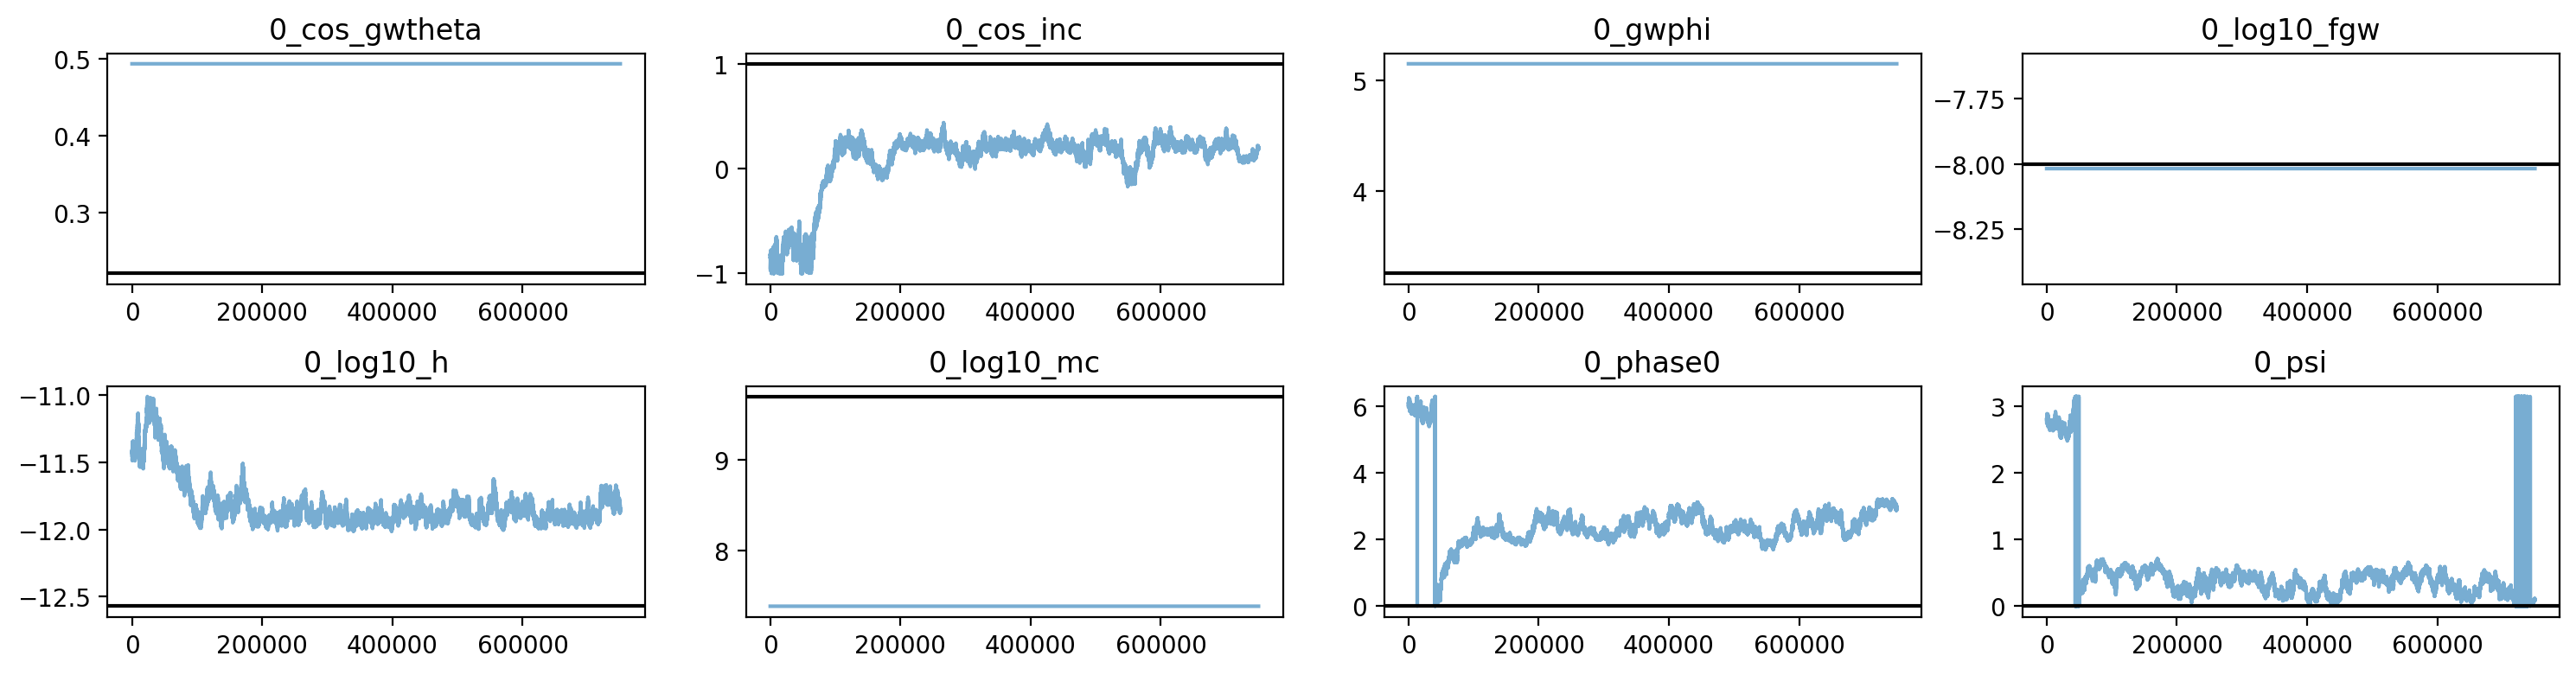

In [41]:
burn = int(len(samples)/4)

# plot trace plots of the CW parameters
plt.figure(figsize=(15, 2*2))
for j in range(len(injected)):
    plt.subplot(2, 4, j+1)
    plt.plot(samples[burn:,j], alpha=0.6, color='C0')
    plt.title(par_names[j]) #parameter name
    plt.axhline(injected[j], color='k') #injected value
plt.tight_layout()

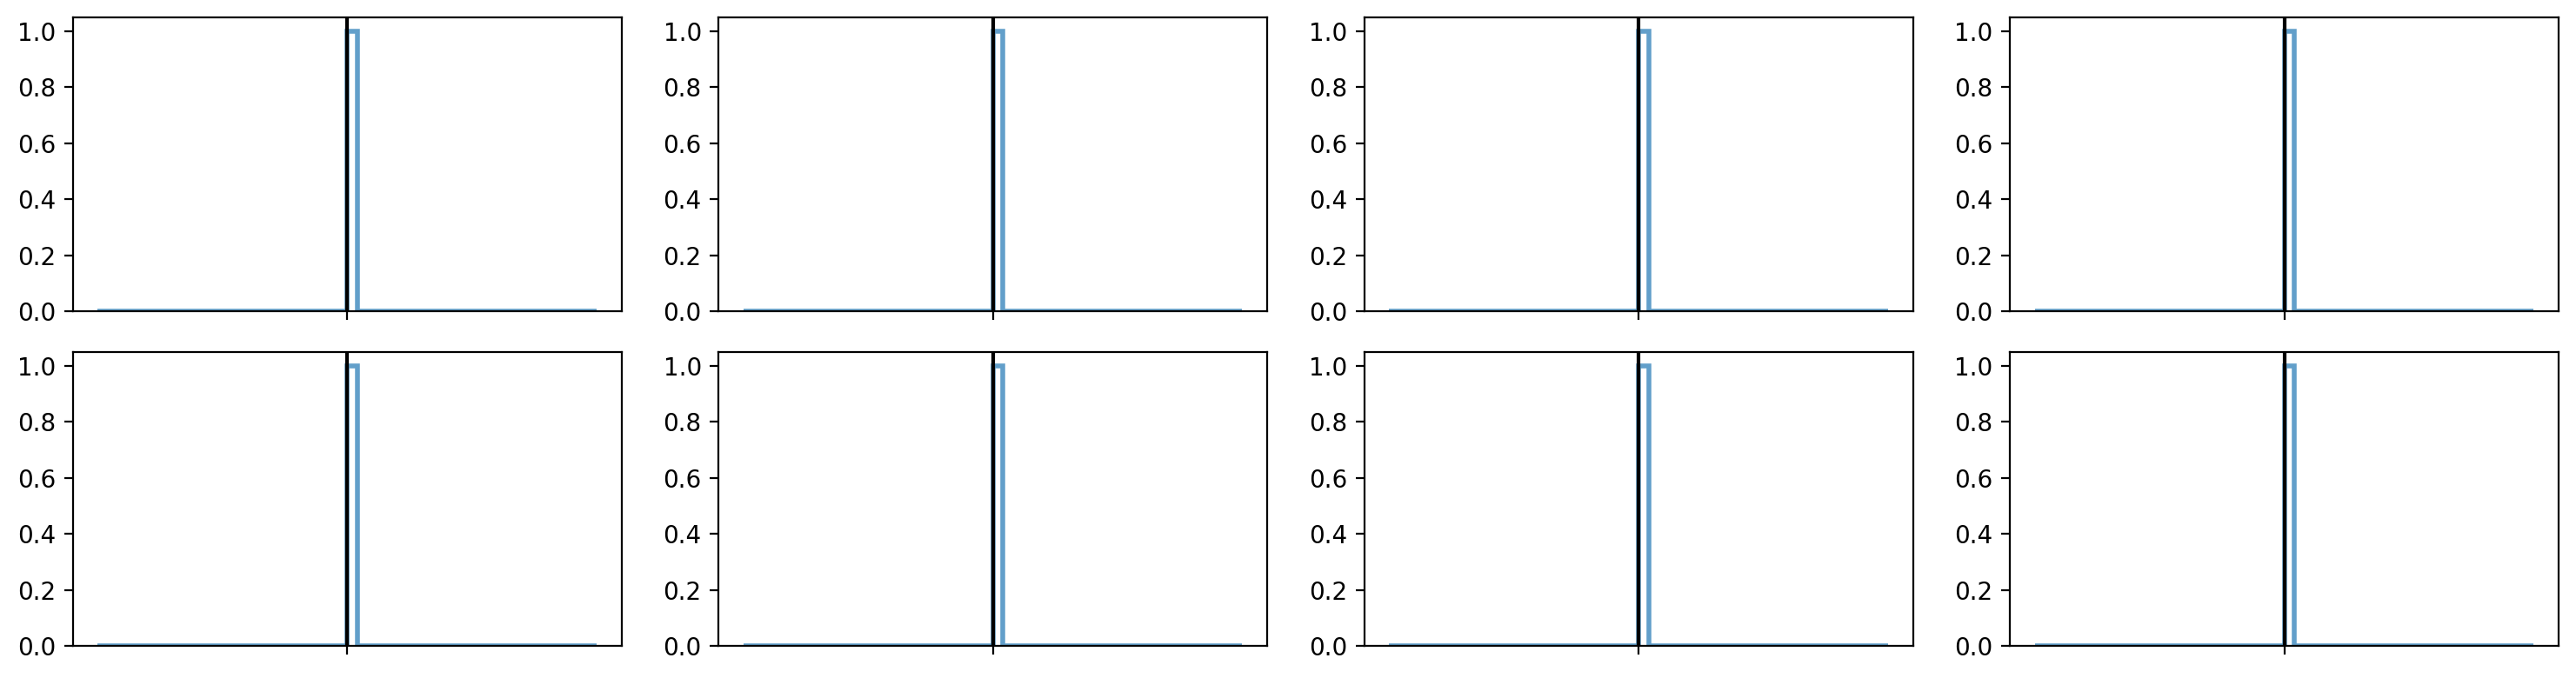

In [42]:
# plot histograms of the CW parameter samples
plt.figure(figsize=(15, 2*2))
for j in range(len(injected)):
    plt.subplot(2, 4, j+1)
    plt.hist(___, bins=50, histtype='step', lw=2, alpha=0.7, color='C0')
    plt.title(___) #parameter name
    plt.axvline(___, color='k') #injected value
plt.tight_layout()

In [43]:
# corner plot
fig = corner.corner(___, levels=[0.68,0.95],
                    truths=___, truth_color='k', labels=___, color='C0')
plt.show()

ImportError: Please install arviz or use a numpy array as input

**Was your `QuickCW` run able to recover the injected parameters?**

If yes, great! If not, it's no big deal. There's many reasons why this dataset might be hard to work with. First, we're only working with 3 pulsars, and (if you refer back to the antenna pattern skymaps at the beginning of this notebook) not all 3 pulsars are close to the CW source on the sky. We've also taken the simplest case when it comes to the pulsars' distances, placing them all at 1 kpc, with considerable uncertainties on the distance (+/- 0.2 kpc). Plus, our dataset only spans 10 years, so we might need additional years' worth of data to be able to extract the signal. 

Let's look at one more diagnostic before we move on our test run. In addition to our MCMC chain output, it can also be helpful to visualize our results by comparing the CW signal made by the injected parameters versus the CW signal made by the recovered parameters. See how they compare below.

In [ ]:
# make dictionary of maximum a posteriori (MAP) recovered values for CW parameters
recovered = {}
for j,param in enumerate(par_names):
    if 'red' not in param and 'gwb' not in param: #we only want CW params, not RN params
        hist, bins = np.histogram(samples[burn:,j], bins=50)
        bin_mid = 0.5 * (bins[1:] + bins[:-1])
        idx = np.argsort(hist)[-1]
        MAP = bin_mid[idx]
        recovered.update({param: MAP})

In [ ]:
# plot comparison
plt.figure(figsize=(25, 3.5*n_psrs))

for i, psr in enumerate(epsrs):
    ax = plt.subplot(n_psrs, 3, i+1)

    # injected CW signal for each pulsar
    cw_in = cw_delay(psr.toas, psr.pos, pdist=(1.0, 0.2),
                     cos_gwtheta=np.cos(gwtheta_in), gwphi=gwphi_in, log10_dist=np.log10(dist_in), 
                     log10_fgw=np.log10(fgw_in), log10_mc=np.log10(mc_in),
                     cos_inc=np.cos(inc_in), psi=psi_in, phase0=phase0_in, p_dist=0,
                     psrTerm=True, evolve=False, phase_approx=True, tref=tref)

    # recovered CW signal for each pulsar
    cw_out = cw_delay(psr.toas, psr.pos, pdist=(1.0, 0.2),
                      cos_gwtheta=recovered['0_cos_gwtheta'], gwphi=recovered['0_gwphi'], log10_h=recovered['0_log10_h'], 
                      log10_fgw=recovered['0_log10_fgw'], log10_mc=recovered['0_log10_mc'],
                      cos_inc=recovered['0_cos_inc'], psi=recovered['0_psi'], phase0=recovered['0_phase0'], p_dist=0,
                      psrTerm=True, evolve=False, phase_approx=True, tref=tref)

    # plot both signals
    ax.plot((psr.toas*u.second).to(u.day), cw_in, color=f'C{i}', marker='', alpha=1, lw=2, label='injected')
    ax.plot((psr.toas*u.second).to(u.day), cw_out, color=f'C{i}', marker='', alpha=1, ls='--', lw=2, label='recovered')
    ax.set_ylim(-1.8e-5, 1.8e-5)
    ax.legend(loc='upper right', fontsize=14)

**Any similarities between the two waveforms?**

### Explore results with an example chain

For now, let's take an example chain from a `QuickCW` analysis that **did** recover the parameters well and get some more practice with chain diagnostics. This analysis was done on a more realistic NANOGrav-12.5yr-like-dataset containing a CW signal.

Download the chain from the Google Drive link below and place it in the `qcw_samples` directory:<br>
https://drive.google.com/file/d/13pFWERhO9Z6p-BL3m33RRyY--LWQsG6q/view?usp=sharing

In [ ]:
# load example pulsars (this is the simulated dataset)
with open(outdir+'sim_data/example_dataset.pkl', 'rb') as expkl:
    ex_psrs = pickle.load(expkl)

In [ ]:
# load example chain file
ex_file = savedir+'example_chain.h5'
with h5py.File(ex_file, 'r') as ff:
    chain = ff['samples_cold'][0,::,:]
    print('Number of samples:', chain.shape)
    par_names = [x.decode('UTF-8') for x in list(ff['par_names'])]
    log_likelihood = ff['log_likelihood'][:,::]

**Plot the trace plots and histograms for the 8 CW parameters, and find their MAP values.**

In [ ]:
# set burn-in
burn = int(len(chain)/4)

# plot trace plots here



In [ ]:
# plot histograms here



In [ ]:
# plot corner plot here



In [ ]:
# find MAP values here



**Using the injected values provided below, make some comparisons between the recovered values and injected values. Plot the recovered and injected waveforms for all 45 pulsars $-$ how well do they compare?**

In [ ]:
# injected CW parameters for this dataset

# sky location
ex_ra = (15*(13 + 0/60 + 8.09/3600))
ex_dec = 27 + 58/60 + 37.2/3600
ex_gwphi = ex_ra*np.pi/180
ex_gwtheta = np.pi/2 - ex_dec*np.pi/180

# distance, frequency, chirp mass, strain
ex_dist = 112.2
ex_fgw = 2e-8
ex_M = 10**(10.32)
ex_q = 0.005
ex_mc = ex_M * (ex_q/(1+ex_q)**2)**(3/5)
ex_h = (2 * (ex_mc*const.Tsun)**(5/3) * (np.pi * ex_fgw)**(2/3) / ex_dist) / const.Mpc * const.c

# angular parameters
ex_inc = 0.0
ex_psi = np.pi/4.0
ex_phase0 = 0.0

ex_injected = [np.cos(ex_gwtheta), np.cos(ex_inc), ex_gwphi, np.log10(ex_fgw), np.log10(ex_h), np.log10(ex_mc), ex_phase0, ex_psi]

In [ ]:
# plot histograms of the CW parameter samples
# include one vertical line for the recovered MAP value, and one vertical line for the injected value



In [ ]:
# plot waveform comparison

tref = min([p.toas.min() for p in ex_psrs])
n_psrs = 45
plt.figure(figsize=(25, 3.5*n_psrs))

for i, psr in enumerate(ex_psrs):
    ax = plt.subplot(n_psrs, 3, i+1)
    
    # injected CW signal for each pulsar
    cw_in = cw_delay(psr.toas, psr.pos, pdist=psr.pdist,
                     # insert other parameters here
                    
                    )

    # recovered CW signal for each pulsar
    cw_out = cw_delay(psr.toas, psr.pos, pdist=psr.pdist,
                      # insert other parameters here
                     
                     )

    # plot signals
    ax.plot((psr.toas*u.second).to(u.day), cw_in, color=f'C{i}', marker='', alpha=1, lw=2, label='injected')
    ax.plot((psr.toas*u.second).to(u.day), cw_out, color=f'C{i}', marker='', alpha=1, ls='--', lw=2, label='recovered')
    ax.set_ylim(-1e-7, 1e-7)
    ax.legend(loc='upper right', fontsize=14)

# 5. Signal localization

One of most important pieces of information we can obtain from an MCMC analysis is the **sky location of the CW source**. If we know where the GW signal came from on the sky, we can then look for host galaxies in that region, or potential electromagnetic signatures of supermassive binaries, in the hopes that we can connect the two in a multi-messenger detection. As a teaser for the next tutorial, let's  get a sense of how much information the `QuickCW` run gives us about the CW's sky location.

In [ ]:
# we need our cos_gwtheta samples and gwphi samples
costheta_samples = chain[:,0]
phi_samples = chain[:,2]
sky_samples = np.stack([costheta_samples,phi_samples], axis=1)

First, let's see how the injected values compare to the signal localization using a corner plot.

In [ ]:
# corner plot
corner.corner(sky_samples[burn:,0:2], levels=[0.68,0.95],
              truths=[np.cos(ex_gwtheta),ex_gwphi], truth_color='k', labels=['cos_gwtheta','gwphi'], color='C0')
plt.show()

### Skymap visualization with `healpy`

Looks like the GW signal is recovered fairly well! Now let's see where this region lies on the sky using `healpy`. This software package uses the **H**ierarchical **E**qual **A**rea iso**L**atitude **Pix**elization (HEALPix) scheme, which basically means that it subdivides the sky into pixels that each cover the same surface area. See this link for more info and some nice graphics to illustrate this: https://healpix.jpl.nasa.gov/

First, we need to transform our samples into a HEALPix map, which we'll do using the function below. The function takes in our sky location samples as well as a parameter called $N_{\rm{side}}$, which is the resolution of our skymap. The lowest resolution is $N_{\rm{side}} = 1$, which will split the sky into $12N_{\rm{side}}^2$ equal-area pixels. $N_{\rm{side}}$ values must be a power of 2, i.e., 1, 2, 4, 8, 16, and so on. We'll start with $N_{\rm{side}}=8$, which is a total of 768 pixels.

In [ ]:
# function to convert samples into a HEALPix map of number counts

def post2hpx(theta, phi, nside=8):
    
    # converts nside resolution to total number of pixels
    # (this is 768 for nside=8)
    npix = hp.nside2npix(nside) 
    
    # based on a given nside resolution,
    # takes sky samples and assigns a pixel index to each sample
    # (for nside=8 each sample will be assigned a value of 0 through 767 based on where it lies on the sky)
    indices = hp.ang2pix(nside, theta, phi)

    # determine how many samples correspond to each pixel
    # this will give us the density of our samples across the sky
    idx, counts = np.unique(indices, return_counts=True)
    
    # make a blank skymap and then fill it with the counts, or density, of samples
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts

    return hpx_map

In [ ]:
# make the healpy map
hpx_map = post2hpx(np.arccos(costheta_samples), phi_samples, nside=8)

**Take some time to understand what this function is doing.** Print out each step if you need to! When you feel comfortable with the samples-to-skymap conversion, run the cell below to see the skymap.

In [ ]:
# we're using a mollweide projection map - this is pretty standard
hp.mollview(hpx_map, rot=180, hold=True, title='')

# plot pulsar positions
for i, psr in enumerate(ex_psrs):
    hp.visufunc.projscatter(psr.theta, psr.phi, marker='*', s=70, color='lightblue')

# plot GW source location
hp.visufunc.projscatter(ex_gwtheta, ex_gwphi, marker='x', s=50, color='r')

# plot axis labels by hand (healpy is weird about this)
for i in range(2,24,2):
    text = hp.projtext(i*180/12+3, 4, str(i)+'h', lonlat=True, coord='G', fontsize='medium', zorder=1, color='w')
for i in range(-75,0,15):
    text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='medium', zorder=10, color='w')
for i in range(15,90,15):
    text = hp.projtext(180, i, str(i)+'$^\circ$', lonlat=True, coord='G', fontsize='medium', zorder=10, color='w')

# plot grid lines
hp.graticule(15, 30, color='gray')
plt.show()

The colored pixels correspond to our posterior samples, with yellow pixels having more samples. See the colorbar for the number of samples lying in each pixel. **Feel free to play around with the resolution of the map by changing the $N_{\rm{side}}$ value** (with higher $N_{\rm{side}}$ being higher resolution). 

For reference, we've also plotted this simulated array's pulsars in light blue, and the red X marker is the true injected sky location.

### This is still a pretty broad region of the sky. How do we narrow down where the GW signal is coming from?

Even by eye, we can see that the localization area in the skymap we just plotted spans about 30 deg x 30 deg = 900 deg$^2$! That's a pretty large chunk of the sky that we need to search through to find the host galaxy of the SMBHB emitting the GW signal. Assuming we've detected a signal, how do we calculate the localization area more precisely? How many potential host galaxies lie in this area? Can we sift through these galaxies and eliminate some of them as host candidates? **Stay tuned $-$ we'll explore these and other questions in the next tutorial!**